### Imports

In [191]:
import re
import nltk
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from keras import metrics
from sklearn.svm import SVC
from tensorflow import keras
from textblob import TextBlob
from keras import backend as K
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from keras.optimizers import RMSprop
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import VotingClassifier
from keras.preprocessing.text import Tokenizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.layers import Dense, Embedding, LSTM, GlobalAveragePooling1D, Flatten
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [314]:
warnings.filterwarnings("ignore")

In [370]:
df_train=pd.read_csv('Sarcasm Detection Dataset/Train.csv')
df_test=pd.read_csv('Sarcasm Detection Dataset/Test.csv')

In [371]:
df_train.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


In [372]:
def EDA(data):
    display(data.drop([],axis=1).describe())
    sns.heatmap(data.drop([],axis=1).corr())
    data.isna().sum()

### Cleaning

In [373]:
#Entire dataset
def clean_and_process(data):
#     data['top'].fillna(data['top'].median(), inplace = True)
#     data['top'].fillna(data['top'].mode()[0], inplace = True)
#     data.fillna({x:'' for x in ['summary','positives', 'negatives','advice_to_mgmt']}, inplace=True)
    
    drop_column = ['user']
    data.drop(drop_column, axis=1, inplace = True)
    
    # Embedding for LSTM
    tkn = Tokenizer(num_words=10000)
    tkn.fit_on_texts(data['comment'])
    data['tokenized'] = tkn.texts_to_sequences(data['comment'])
    max_pad_length = data.tokenized.map(lambda x: len(x)).max()
    data['tokenized'] =pad_sequences(df_train['tokenized'], maxlen= max_pad_length, padding='pre').tolist()
    

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token for token in tokens]
    return words
clean_and_process(df_train)

### Feature Engineering

In [375]:
def features(data):
    data['date']=pd.to_datetime(data.date, errors='coerce')
    data['month']=data.date.dt.month_name()
    data['day']=data.date.dt.day_name()
    data['year']=data.date.dt.year
    data['prod']=data['top']*data['down']
    topicscore=data.groupby('topic').score.mean()
    #score
    data['topic_score']=data.topic.apply(lambda x:topicscore[x])
    data['diff_score']=data['topic_score']-data['score']
    
    #count 
    data['comma_count'] = data['comment'].apply(lambda x: str(x).count(','))
    data['ex_count'] = data['comment'].apply(lambda x: str(x).count('!'))
    data['quot_count'] = data['comment'].apply(lambda x: str(x).count('"'))
    data['ques_count'] = data['comment'].apply(lambda x: str(x).count('?'))
    data['hash_count'] = data['comment'].apply(lambda x: str(x).count('#'))
    data['upper_count'] = data['comment'].apply(lambda x: sum([1 for i in str(x) if i.isupper()]))
    
    data['p_comma_count'] = data['parent_comment'].apply(lambda x: str(x).count(','))
    data['p_ex_count'] = data['parent_comment'].apply(lambda x: str(x).count('!'))
    data['p_quot_count'] = data['parent_comment'].apply(lambda x: str(x).count('"'))
    data['p_ques_count'] = data['parent_comment'].apply(lambda x: str(x).count('?'))
    data['p_hash_count'] = data['parent_comment'].apply(lambda x: str(x).count('#'))
    data['p_upper_count'] = data['parent_comment'].apply(lambda x: sum([1 for i in str(x) if i.isupper()]))
    
    data['wlen_avg']= data['comment'].apply(lambda x:np.mean([len(i) for i in x.split()]))
    data['wlen_max']=data['comment'].apply(lambda x:np.max([len(i) for i in x.split()]))
    data['first']=data['comment'].apply(lambda x:str(x).lower().split(' ')[0])
    data['last']=data['comment'].apply(lambda x:str(x).lower().split(' ')[-1])
    data['com_par']=data['comment']+' '+data['parent_comment']
    
    data['parent_comment_len'] = data['parent_comment'].apply(lambda x: len(str(x).split(" ")))
    data['comment_len'] = data['comment'].apply(lambda x: len(str(x).split(" ")))
    
    data['comment_sentiment']= data['comment'].apply(lambda x:TextBlob(str(x)).sentiment.polarity)
    data['parent_comment_sentiment']= data['parent_comment'].apply(lambda x:TextBlob(str(x)).sentiment.polarity)
    data['com_par_sentiment']= abs(data['comment_sentiment']-data['parent_comment_sentiment'])

In [376]:
features(df_train)
features(df_test)

### EDA

,down,score,top,label,year,prod,topic_score,diff_score,comma_count,ex_count,...,p_ques_count,p_hash_count,p_upper_count,wlen_avg,wlen_max,parent_comment_len,comment_len,comment_sentiment,parent_comment_sentiment,com_par_sentiment
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,-0.145333,7.194667,5.457600,0.501800,2015.051533,0.145333,7.194667,6.723155e-15,0.392533,0.094600,...,0.321733,0.009133,5.219267,4.763506,8.549000,24.376467,10.475667,0.060618,0.054030,0.267545
std,0.352448,46.586034,32.236574,0.500013,1.215693,0.352448,10.725057,4.533466e+01,0.732544,0.302308,...,0.730290,0.166889,13.260401,4.492343,5.408643,41.755339,8.141988,0.285553,0.269332,0.270083
min,-1.000000,-111.000000,-111.000000,0.000000,2009.000000,0.000000,-38.000000,-2.719455e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,2015.000000,0.000000,3.222222,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,1.000000,4.000000,7.000000,8.000000,5.000000,0.000000,0.000000,0.041667
50%,0.000000,2.000000,1.000000,1.000000,2015.000000,0.000000,5.732283,2.571429e+00,0.000000,0.000000,...,0.000000,0.000000,3.000000,4.500000,8.000000,14.000000,9.000000,0.000000,0.000000,0.200000
75%,0.000000,4.000000,3.000000,1.000000,2016.000000,0.000000,8.622378,6.773869e+00,1.000000,0.000000,...,0.000000,0.000000,5.000000,5.084239,10.000000,26.000000,14.000000,0.175000,0.175000,0.404779
max,0.000000,2993.000000,1340.000000,1.000000,2016.000000,1.000000,495.000000,2.735455e+02,18.000000,8.000000,...,23.000000,11.000000,720.000000,524.000000,524.000000,1770.000000,134.000000,1.000000,1.000000,1.800000


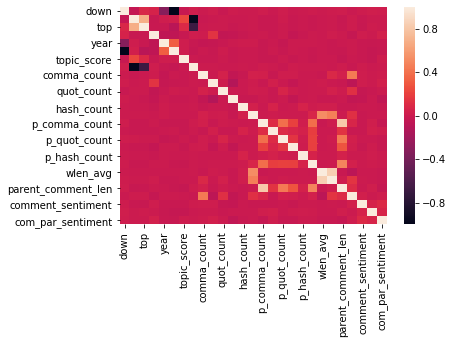

In [377]:
EDA(df_train)

### Top words

In [395]:
 stwd=set(stopwords.words('english'))

In [ ]:
top=pd.concat(
        [
            pd.Series([i for i in  " ".join(df_train[df_train.label==0].comment).split()  if i not in stwd]).value_counts()[:15].reset_index(),
            pd.Series([i for i in  " ".join(df_train[df_train.label==1].comment).split()  if i not in stwd]).value_counts()[:15].reset_index()
        ],axis=1)
top.columns=['Regular', 'RCount','Sarcastic','SCount']
display(top)

In [396]:
X = df_train.drop('label', axis=1)
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

In [397]:
X_train.columns.tolist()

['ID',
 'comment',
 'date',
 'down',
 'parent_comment',
 'score',
 'top',
 'topic',
 'tokenized',
 'month',
 'day',
 'year',
 'prod',
 'topic_score',
 'diff_score',
 'comma_count',
 'ex_count',
 'quot_count',
 'ques_count',
 'hash_count',
 'upper_count',
 'p_comma_count',
 'p_ex_count',
 'p_quot_count',
 'p_ques_count',
 'p_hash_count',
 'p_upper_count',
 'wlen_avg',
 'wlen_max',
 'first',
 'last',
 'com_par',
 'parent_comment_len',
 'comment_len',
 'comment_sentiment',
 'parent_comment_sentiment',
 'com_par_sentiment']

### PreProcessing

In [380]:
categorical_columns=['topic','first','last','month','day','year']
text_columns='comment'
numerical_columns=[
                   'top','down','score','diff_score','prod',
                    'wlen_avg','wlen_max',
                   'parent_comment_sentiment','comment_sentiment','com_par_sentiment',
                   'parent_comment_len','comment_len',
                  'comma_count','ques_count','ex_count','quot_count','hash_count','upper_count',
                  'p_comma_count','p_ques_count','p_ex_count','p_quot_count','p_hash_count','p_upper_count'
]


categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',categories='auto'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
    ,('scaler',StandardScaler())
])
text_pipe= Pipeline([('vect', CountVectorizer(stop_words='english', tokenizer=textblob_tokenizer,decode_error='ignore',ngram_range=(1, 2),max_features=500000, min_df=4)),
    ('tfidf', TfidfTransformer())]) #TfidfVectorizer for both
partext_pipe= Pipeline([('par_vect', CountVectorizer(stop_words='english', tokenizer=textblob_tokenizer,decode_error='ignore',ngram_range=(1, 2),max_features=500000, min_df=4)),
    ('tfidf', TfidfTransformer())]) #TfidfVectorizer for both


preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns)
     ,('num', numerical_pipe, numerical_columns)
     ,('text',text_pipe,text_columns)
     ,('ptxt',partext_pipe,'parent_comment')
    ])


### Model Selection

In [324]:
clfs=[]

classifiers = [
    KNeighborsClassifier(algorithm='kd_tree',n_neighbors=3),
    LogisticRegression(penalty='l1'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessing),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    clfs.append(pipe.named_steps['classifier'])
    print(classifier)
    print("model score: %.3f" % f1_score(y_test, pipe.predict(X_test),average='weighted'))
    print('----------------------------------------------------------')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
model score: 0.534
----------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
model score: 0.663
----------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
model score: 0.588
-----------------------------------------

In [235]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="grey" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

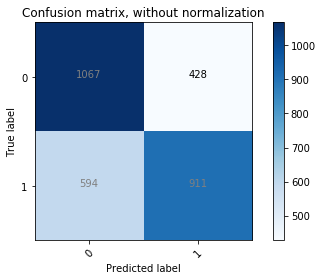

In [236]:
cnf_matrix = confusion_matrix(y_test, pipe.predict(X_test))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=[0,1],title='Confusion matrix, without normalization')

### Hyper parmeter Tuning / GridSearchCV (time consuming)

In [237]:
#param_grid={'C': np.logspace(-2, 10, 13)}
# params = {'classifier__loss': ['deviance'],
#  'classifier__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#  'classifier__min_samples_split': [0.1 , 0.14, 0.17, 0.21, 0.25, 0.28, 0.32, 0.35, 0.39, 0.43, 0.46,
#         0.5 ],
#  'classifier__min_samples_leaf': [0.1 , 0.14, 0.17, 0.21, 0.25, 0.28, 0.32, 0.35, 0.39, 0.43, 0.46,
#         0.5 ],
#  'classifier__max_depth': [3, 5, 8],
#  'classifier__max_features': ['log2', 'sqrt'],
#  'classifier__criterion': ['friedman_mse', 'mae'],
#  'classifier__subsample': [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#  'classifier__n_estimators': [10]}

# cv = KFold(5)
# pipe = Pipeline([
#     ('preprocess', preprocessing)
#     ,('classifier', GradientBoostingClassifier())
    
# ])
# grid_search = GridSearchCV(pipe, params, cv=cv)
# grid_search.fit(X_train,y_train)
# print(grid_search.best_params_)

In [238]:
# f1_score(y_test,grid_search.best_estimator_.predict(X_test),average='weighted')

### Feature Selection

In [239]:
# F-1 score
cls = Pipeline([
    ('preprocessor', preprocessing)
    ,('feature_selection', SelectFromModel(LogisticRegression(penalty='l1'),threshold='1.5*mean'))
    ,('classifier',GradientBoostingClassifier() )
    
])

cls.fit(X_train,y_train)
f1_score(y_test,cls.predict(X_test),average='weighted')

0.6506695562079295

### Feature Importance

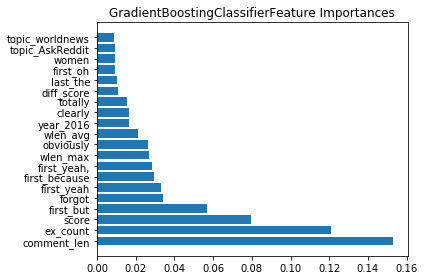

In [240]:
ohe = (cls.named_steps['preprocessor']
         .named_transformers_['cat']
         .named_steps['onehot'])
text_columns=cls.named_steps['preprocessor'].named_transformers_['text'].named_steps['vect'].get_feature_names()
ptext_columns=cls.named_steps['preprocessor'].named_transformers_['ptxt'].named_steps['par_vect'].get_feature_names()

feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns,text_columns,ptext_columns]
feature_names=feature_names[cls.named_steps['feature_selection'].get_support()]

feature_importances = (
    cls.named_steps['classifier'].feature_importances_)

sorted_idx = feature_importances.argsort()[::-1]
top_k = 20
y_ticks = np.arange(0, top_k)
fig, ax = plt.subplots()
ax.barh(y_ticks, feature_importances[sorted_idx[:top_k]])
ax.set_yticklabels(feature_names[sorted_idx[:top_k]])
ax.set_yticks(y_ticks)
ax.set_title(cls.named_steps['classifier'].__class__.__name__+"Feature Importances")
fig.tight_layout()
plt.show()

### Ensemble Models

In [270]:

eclf1 = VotingClassifier(estimators=[
        ('xgb', XGBClassifier()), ('gbc', GradientBoostingClassifier()), ('lg', LogisticRegression(penalty='l1'))], voting='hard')


ecls = Pipeline([
    ('preprocessor', preprocessing)
    ,('feature_selection', SelectFromModel(LogisticRegression(penalty='l1'),threshold='mean'))
    ,('classifier',eclf1 )
    
])


ecls.fit(X_train,y_train)
f1_score(y_test,ecls.predict(X_test),average='weighted')




0.6658808993919003

## Using LSTM (Comment text only)

In [381]:
transformer = FunctionTransformer(pad_sequences,kw_args={'maxlen': max_pad_length, 'padding':'pre'},validate=False)

def build_model():
    def f1(y_true, y_pred):
        def recall(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_true, y_pred):
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    embed_size = 128
    model = Sequential()

    #Embedding Layer
    model.add(Embedding( total_words,embed_size))

    #LSTM input layer
    model.add(LSTM(embed_size, activation='relu'))

    #Intermediate layer
    model.add(Dense(64, activation ='relu'))

    #OutputLayer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer='adam')
   
    print(model.summary())
    #accuracy = model.evaluate(X_test, y_test)[1]
    return model

In [165]:
lstm_model = build_model()
lstm.fit(transformer.fit_transform(X_train.tokenized),y_train,epochs=2)
y_pred=lstm_model.predict(transformer.fit_transform(X_test.tokenized),y_test)[0]

y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1


print(f1_score(y_test.to_numpy(),y_pred,average='weighted'))

0.6944964118188759


In [ ]:
lstm_model = build_model()
lstm_model.fit(transformer.fit_transform(X_train.tokenized),y_train,epochs=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, None, 128)         2276352   
_________________________________________________________________
lstm_48 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_89 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_45 (Activation)   (None, 1)                 0         
Total params: 2,416,257
Trainable params: 2,416,257
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
 9152/12000 [=====================>........] - ETA: 2:02 - loss: 0.6721

In [285]:
y_pred=lstm_model.predict(preprocess_lstm(X_test,y_test)[0])

y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1


print(f1_score(y_test.to_numpy(),y_pred,average='weighted'))

0.6581297704997127


In [269]:
f1_score(y_test,y_pred.reshape(1,-1)[0],average='weighted')

0.6517789623109864

### LSTM + XGBoost Together

In [432]:
prepadding = ColumnTransformer(
    [('pre', transformer , 'tokenized')])

ed = VotingClassifier(estimators = [
    ('xgb',Pipeline([('preprocessor', preprocessing),('feature_selection', SelectFromModel(LogisticRegression(penalty='l1'),threshold='mean')),('classifier', XGBClassifier())])),
    ('tkpd',Pipeline([('token_prepadding',prepadding ),('lstm',build_model())]))], voting='hard')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, None, 128)         2276352   
_________________________________________________________________
lstm_45 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_83 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_42 (Activation)   (None, 1)                 0         
Total params: 2,416,257
Trainable params: 2,416,257
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
ed.fit(X_train,y_train)
f1_score(y_test,ed.predict(X_test),average='weighted')


### Pickle/ Save to File

In [51]:
#check
df_test['label']=cls.predict(df_test)
df_test['label'].value_counts()

0    4634
1    3366
Name: label, dtype: int64

In [ ]:
# import pickle
# s = pickle.dumps(cls)
# cls_loaded = pickle.loads(s)

In [342]:
output_columns=['ID','label']
df_test[output_columns].to_csv('Dataset/submission.csv', index= False)